In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
from scipy.ndimage.interpolation import geometric_transform
import statsmodels.api as sm
from pathlib import Path
import re
import os
from simcore_tools import FileRenamer

In [57]:
def find_param(string, param):
    string = string.rpartition('/')[-1]
    string = string.rpartition('.')[0]
    start = string.find(param)
    if start == -1:
        if param == 'reload':
            return '000'
        else:
            return 'NA'
    end = string[start:].find('_')
    if end == -1:
        return string[start+len(param):]
    else:
        return string[start+len(param):start+end]


def createFileList(extension, dirName='.'):
    """Returns a pandas series consisting of all files with the provided
    extension in directory dirName, defaulting to the current working
    directory.
    """
    file_names = [os.path.join(dirName, file) for file in os.listdir(dirName) 
                  if file.rpartition('.')[-1] == extension]
    if len(file_names) == 0:
        raise ValueError("No '" + extension + "' files found in directory '"
              + dirName + "'.")
    if re.search('v[0-9]{3}', file_names[0]):
        raise ValueError("Filename found with 'vXXX' in name. "
                         "Did you forget to rename the filenames before running the analysis?")
    file_names.sort()
    return pd.Series(file_names)

def check_directory_exists(dirname):
    if not Path(dirname).is_dir():
        print("Save directory not found:", dirname)
        var = input("Create it? (y/N) ")
        if (var == 'y' or var == 'Y'):
            try:
                os.mkdir(dirname)
            except Exception as e:
                print("Creation of directory", dirname, "failed!")
                raise e
        else:
            raise ValueError("Save directory does not exist:", dirname)

def initializeDataFrame(dirName='.',
                        params=['pf', 'sp', 'lp'],
                        analyses=['global_order']):
    """Generates dataframe of all simcore analysis files, assuming
    file naming convention of containing the substrings listed in the
    params list, followed by the parameter quantity and an underscore.
    This function tabulates these quantities using the file names of any
    bitmaps (final state snapshots) found in snapshotDir. It then looks
    for the corresponding analyses files whose extension is given by the
    substrings found in the analyses list.
    """
    df = None
    params = params + ['reload']
    for analysis in analyses:
        analysis_df = pd.DataFrame(data=createFileList(analysis, dirName), columns=[analysis])
        for param in params:
            analysis_df[param] = analysis_df[analysis].apply(find_param, args=(param,))
        if df is not None:
            df = pd.merge(df, analysis_df, how='outer', on=params)
        else:
            df = analysis_df
    return df[params + analyses]

In [59]:
def get_global_order_data(df, saveDirName=".", make_plots=True, params=['pf', 'sp', 'lp'], 
                          late_fraction=0.1, rolling_window=20):
    """Generates two grids of plots displaying time series of the global
    order parameters, including the global polar/nematic order on one
    figure and global spiral number/spiral handedness on a second figure.
    """
    
    analyze = 'global_order'
    check_directory_exists(saveDirName)
    gby = df.groupby(params)
    row_list = []
    for values, group in gby:
        param_values = [i for pair in zip(params, values) for i in pair]
        string_values = str.join('_', ['{}{}' for i in range(len(params))])
        string_values = string_values.format(*param_values)
        display_values = str.join(', ', ['{}={}' for i in range(len(params))])
        display_values = display_values.format(*param_values)
        
        print("Gathering", analyze, "data for parameters", display_values)
        goDF = None
        for file in group[analyze].sort_values():
            if goDF is not None: 
                goDF = goDF.append(GetGlobalOrderDF(file), ignore_index=True)
            else:
                goDF = GetGlobalOrderDF(file)

        if (make_plots):
            plotDF = goDF.rolling(rolling_window).mean().dropna()
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            plotDF.plot(y="nematic_order_mag",color='blue',linewidth=1,ax=ax[0])
            plotDF.plot(y="polar_order_mag",color='red',linewidth=1,ax=ax[0])
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel('Orientational order')
            ax[0].legend(['Nematic order', 'Polar order'])
            ax[0].set_ylim(0, 1)
            plotDF.plot(y="spiral_order",color='blue',linewidth=1,ax=ax[1])
            plotDF.plot(y="signed_spiral_order",color='red',linewidth=1,ax=ax[1])
            ax[1].set_xlabel('Time')
            ax[1].legend(['Spiral order', 'Spiral handedness'])
            ax[1].set_ylabel('Spiral order')
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig.suptitle("Global order parameters: " + display_values)
            print("Saving", analyze, "plots for parameters", display_values)
            fig.savefig(Path(saveDirName, string_values + "_global_order.png"))
            plt.close(fig)
            
        result_names = ['global_polar', 'global_polar_std', 
                        'global_nematic', 'global_nematic_std',
                        'global_spiral', 'global_spiral_std']
        late_time = int((1 - late_fraction)*goDF.shape[0])
        results = (goDF['polar_order_mag'].iloc[late_time:].mean(), 
                   goDF['polar_order_mag'].iloc[late_time:].std(),
                   goDF['nematic_order_mag'].iloc[late_time:].mean(), 
                   goDF['nematic_order_mag'].iloc[late_time:].std(),
                   goDF['spiral_order'].iloc[late_time:].mean(), 
                   goDF['spiral_order'].iloc[late_time:].std())
        row = {key:value 
               for key, value 
               in (list(zip(params, values)) + list(zip(result_names, results)))}
        row_list.append(row)
    return pd.DataFrame(row_list)


def CalculateGlobalOrderMagnitudes(df):
    """Given a global order dataframe, calculates magnitude of polar
    order vector and maximum eigenvalue of nematic order tensor.
    """
    df['polar_order_mag'] = np.sqrt(df.polar_order_x**2 
                                    + df.polar_order_y**2 
                                    + df.polar_order_z**2)
    df['nematic_order_mag'] = df.apply(lambda x: maxEig(
        x['nematic_order_xx'],
        x['nematic_order_xy'],
        x['nematic_order_yx'],
        x['nematic_order_yy']), axis=1)

    
def maxEig(xx,xy,yx,yy):
    """Returns the max eigenvalue of 2D matrix with elements xx, xy,
    yx, yy.
    """
    return max(np.linalg.eig(np.array([[xx,xy],[yx,yy]]))[0])

    
def GetGlobalOrderDF(fname):
    """Calculates time series of global orders parameters (polar order
    vector magnitude and maximum eigenvalues of nematic order tensor Q)
    from .global_order file with name 'fname' and returns global order
    dataframe.
    """
    assert isinstance(fname,str), "'fname' must be a string!"
    df = pd.read_csv(fname,delim_whitespace=True,skiprows=1,
                     index_col='time').dropna()
    CalculateGlobalOrderMagnitudes(df)
    return df


In [60]:
# Requires time step due to output file header not providing the data...
def get_polar_order_avg_data(df, time_step, saveDirName=".", make_plots=True, 
                             params=['pf', 'sp', 'lp'], late_fraction=0.1, rolling_window=20):
    """Generates two grids of plots displaying time series of the global
    order parameters, including the global polar/nematic order on one
    figure and global spiral number/spiral handedness on a second figure.
    """
    analyze = 'polar_order_avg'
    check_directory_exists(saveDirName)
    gby = df.groupby(params)
    row_list = []
    for values, group in gby:
        param_values = [i for pair in zip(params, values) for i in pair]
        string_values = str.join('_', ['{}{}' for i in range(len(params))])
        string_values = string_values.format(*param_values)
        display_values = str.join(', ', ['{}={}' for i in range(len(params))])
        display_values = display_values.format(*param_values)
        print("Gathering", analyze, "data for parameters", display_values)

        goDF = None
        for file in group[analyze].sort_values():
            if goDF is not None: 
                goDF = goDF.append(pd.read_csv(file, skiprows=1, delim_whitespace=True), 
                                   ignore_index=True)
            else:
                goDF = pd.read_csv(file, skiprows=1, delim_whitespace=True)
        goDF['time'] = goDF.index * time_step
        if make_plots:
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            plotDF = goDF.rolling(rolling_window).mean().dropna()
            plotDF.plot(x="time", y="avg_polar_order", color='red',
                      linewidth=1, ax=ax, label=r'$\langle p_i \rangle$')
            plotDF.plot(x="time", y="avg_contact_number", color='blue',
                      linewidth=1, ax=ax, label=r'$\langle c_i \rangle$')
            ax.set_xlabel('Time')
            ax.set_ylabel('Order parameter')
            ax.set_title('Average local polar order: ' + display_values)
            ax.legend(loc='best')
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
            print("Saving", analyze, "plots for parameters", display_values)
            fig.savefig(Path(saveDirName, string_values + "_local_polar_order_avg.png"))
            plt.close(fig)
        result_names = ['avg_polar_order', 'avg_polar_order_std', 
                        'avg_contact_number', 'avg_contact_number_std']
        late_time = 1 - late_fraction
        results = (goDF['avg_polar_order'].iloc[int(late_time*goDF.shape[0]):].mean(), 
                   goDF['avg_polar_order'].iloc[int(late_time*goDF.shape[0]):].std(),
                   goDF['avg_contact_number'].iloc[int(late_time*goDF.shape[0]):].mean(), 
                   goDF['avg_contact_number'].iloc[int(late_time*goDF.shape[0]):].std())
        row = {key:value 
               for key, value 
               in (list(zip(params, values)) + list(zip(result_names, results)))}
        row_list.append(row)
    return pd.DataFrame(row_list)

In [61]:
def get_flock_df(fname):
    df = pd.read_csv(fname, header=3, low_memory=False, delim_whitespace=True)
    header = pd.read_csv(fname, header=1, nrows=1, delim_whitespace=True)
    filcols = [col for col in df.columns if col[:3] == 'fil']
    flockcols = [col for col in df.columns if col[:3] != 'fil']

    flock_global = df[flockcols].dropna()
    flock_global = flock_global[['n_flocking', 'n_exterior', 'n_interior']]

    flockstates = df[filcols].dropna().values
    n_filaments = flockstates.shape[1]

    flockstates[flockstates == 2] = 3
    diffs = pd.DataFrame(np.diff(flockstates, axis=0))

    freqs = ['f_not_ext', 'f_not_int', 'f_ext_int','f_ext_not', 'f_int_ext', 'f_int_not']
    flock_state = ['n_not', 'n_ext', 'n_int']
    change_state = [1, 3, 2, -1, -2, -3]
    #change_state = [-3, -2, -1, 1, 2, 3]
    df = pd.DataFrame(columns=freqs + flock_state)
    df['n_not'] = n_filaments - flock_global['n_flocking']
    df['n_ext'] = flock_global['n_exterior']
    df['n_int'] = flock_global['n_interior']
    for freq, state in zip(freqs, change_state):
        if freq[2:5] == 'int':
            denom = df['n_int']
        elif freq[2:5] == 'ext':
            denom = df['n_ext']
        elif freq[2:5] == 'not':
            denom = df['n_not']
        else:
            raise ValueError("Unexpected frequency")
        df[freq] = diffs[diffs==state].count(axis=1) / denom
    df = df.iloc[1:-1, :].fillna(0)
    step = 0.5 * header['nspec'][0] * header['delta'][0]
    df['time'] = df.index * step
    for state in flock_state:
        df[state] = df[state] / n_filaments
    df['n_tot'] = 1 - df['n_not']
    return df

def plot_flock_state(df, display_string, save_string, rolling_window=20):
    # Rolling time average with window = 20, 1 tau for nspec = 1000, delta = 0.0001
    time = df['time']
    plotDF = df.rolling(rolling_window).mean().dropna()
    plotDF['time'] = time.iloc[:plotDF.shape[0]]
    # Now plot them
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].set_title('Fraction of flocking filaments')
    ax[0].plot(plotDF['time'], plotDF['n_tot'], label='total')
    ax[0].plot(plotDF['time'], plotDF['n_ext'], label='exterior')
    ax[0].plot(plotDF['time'], plotDF['n_int'], label='interior')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Filament fraction')
    ax[0].legend(loc='best')
    freq_cols = [col for col in df.columns if col[:2] == 'f_']
    plotDF[['time'] + freq_cols].plot(x='time', ax=ax[1], title='Normalized flock switching rates')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xlabel('Time')
    fig.suptitle("Flock dynamics: "+display_string)
    fig.savefig(save_string)
    print("Saving plots for parameters", display_string)
    plt.close(fig)

def get_flock_data(df, saveDirName=".", make_plots=True, params=['pf', 'sp', 'lp'],
                   late_fraction=0.1, rolling_window=20):
    """TODO"""
    analyze = 'flock'
    check_directory_exists(saveDirName)
    gby = df.groupby(params)
    row_list = []
    for values, group in gby:
        param_values = [i for pair in zip(params, values) for i in pair]
        string_values = str.join('_', ['{}{}' for i in range(len(params))])
        string_values = string_values.format(*param_values)
        display_values = str.join(', ', ['{}={}' for i in range(len(params))])
        display_values = display_values.format(*param_values)
        print("Gathering", analyze, "data for parameters", display_values)

        flock_df = None
        for file in group[analyze].sort_values():
            if flock_df is not None: 
                flock_df = flock_df.append(get_flock_df(file), ignore_index=True)
            else:
                flock_df = get_flock_df(file)
        flock_df['time'] = flock_df.index * flock_df['time'].iloc[0]
        
        if make_plots:
            plot_flock_state(flock_df, display_values,
                             Path(saveDirName, string_values + "_flock.png"),
                             rolling_window)
            
        flock_col_names = [col for col in flock_df.columns if col != 'time']
        result_names_std = [name + '_std' for name in flock_col_names]
        result_names = [label 
                        for label_tuple 
                        in zip(flock_col_names, result_names_std) 
                        for label in label_tuple]
        late_time = int((1 - late_fraction)*flock_df.shape[0])
        results = [result
                   for result_tuple
                   in zip([flock_df[name].iloc[late_time:].mean() for name in flock_col_names],
                          [flock_df[name].iloc[late_time:].std() for name in flock_col_names]) 
                   for result in result_tuple]
        row = {key:value 
               for key, value 
               in (list(zip(params, values)) + list(zip(result_names, results)))}
        row_list.append(row)
    return pd.DataFrame(row_list)

In [62]:
params = ['pf', 'sp', 'lp', 'dr']
analyses = [
    'global_order',
    'polar_order_avg',
    'flock'
]
data_dir = Path('data/dr3_pf0.05_results/')

In [64]:
yamls = list(data_dir.glob("*_v*.yaml"))
#yamls

In [65]:
#to_replace = "pf0.05_dr3_v[0-9]{3}"
#replacement = "pf{}_sp{:03d}_lp{:04d}_dr{:02d}"
#formatter_contents = ['filament:packing_fraction', 'soft_potential_mag',
#                      'filament:perlen_ratio', 'filament:driving_factor']
#renamer = FileRenamer(to_replace, replacement, formatter_contents)

In [66]:
#p = Path(data_dir, 'old_params')
#p.mkdir(exist_ok=True)
#for file in yamls:
#    renamer.rename(file, confirm=False)
#    file.replace(Path(p, file.name))

In [75]:
df = initializeDataFrame(data_dir, params, analyses)
df.head()

,pf,sp,lp,dr,reload,global_order,polar_order_avg,flock
0,0.05,005,0005,03,000,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...
1,0.05,005,0005,03,001,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...
2,0.05,005,0010,03,000,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...
3,0.05,005,0010,03,001,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...
4,0.05,005,0020,03,000,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...,data/dr3_pf0.05_results/activeff_pf0.05_sp005_...


In [44]:
# tmpdf = df[((df.lp.astype(int) < 40) & (df.reload == '000'))]
# tmp_go_results = get_global_order_data(tmpdf, 'order_params/plots', make_plots=False, params=params,
#                                   late_fraction=0.1, rolling_window=20)
# tmp_poa_results = get_polar_order_avg_data(tmpdf, time_step=0.05, saveDirName='order_params/plots', make_plots=False)
# tmp_flock_results = get_flock_data(tmpdf, 'order_params/plots', make_plots=False)

In [45]:
# labels_to_drop = []
# for ix in df[((df.reload=='000') & (df.lp.astype(int) < 20))].index:
#     labels_to_drop.append(ix+1)
#     labels_to_drop.append(ix+2)
#     labels_to_drop.append(ix+3)

In [46]:
#df = df.drop(df[(df.sp.astype(int) == 40) & ((df.lp.astype(int) == 10) | (df.lp.astype(int) == 20))].index)

In [50]:
#df = df.drop(df[(df.sp.astype(int) == 200) & ((df.lp.astype(int) == 10) | (df.lp.astype(int) == 20))].index)

In [79]:
df = df.drop(df[(df.sp.astype(int) == 90) & (df.lp.astype(int) == 200)].index)

In [151]:
# df = df.drop(index=labels_to_drop)

In [76]:
# df

In [81]:
go_results = get_global_order_data(df, Path(data_dir, 'plots'), make_plots=True, params=params,
                                  late_fraction=0.1, rolling_window=20)

Gathering global_order data for parameters pf=0.05, sp=005, lp=0005, dr=03
Saving global_order plots for parameters pf=0.05, sp=005, lp=0005, dr=03
Gathering global_order data for parameters pf=0.05, sp=005, lp=0010, dr=03
Saving global_order plots for parameters pf=0.05, sp=005, lp=0010, dr=03
Gathering global_order data for parameters pf=0.05, sp=005, lp=0020, dr=03
Saving global_order plots for parameters pf=0.05, sp=005, lp=0020, dr=03
Gathering global_order data for parameters pf=0.05, sp=005, lp=0030, dr=03
Saving global_order plots for parameters pf=0.05, sp=005, lp=0030, dr=03
Gathering global_order data for parameters pf=0.05, sp=005, lp=0040, dr=03
Saving global_order plots for parameters pf=0.05, sp=005, lp=0040, dr=03
Gathering global_order data for parameters pf=0.05, sp=005, lp=0050, dr=03
Saving global_order plots for parameters pf=0.05, sp=005, lp=0050, dr=03
Gathering global_order data for parameters pf=0.05, sp=005, lp=0060, dr=03
Saving global_order plots for paramet

Saving global_order plots for parameters pf=0.05, sp=030, lp=0070, dr=03
Gathering global_order data for parameters pf=0.05, sp=030, lp=0080, dr=03
Saving global_order plots for parameters pf=0.05, sp=030, lp=0080, dr=03
Gathering global_order data for parameters pf=0.05, sp=030, lp=0090, dr=03
Saving global_order plots for parameters pf=0.05, sp=030, lp=0090, dr=03
Gathering global_order data for parameters pf=0.05, sp=030, lp=0100, dr=03
Saving global_order plots for parameters pf=0.05, sp=030, lp=0100, dr=03
Gathering global_order data for parameters pf=0.05, sp=030, lp=0150, dr=03
Saving global_order plots for parameters pf=0.05, sp=030, lp=0150, dr=03
Gathering global_order data for parameters pf=0.05, sp=030, lp=0200, dr=03
Saving global_order plots for parameters pf=0.05, sp=030, lp=0200, dr=03
Gathering global_order data for parameters pf=0.05, sp=030, lp=0300, dr=03
Saving global_order plots for parameters pf=0.05, sp=030, lp=0300, dr=03
Gathering global_order data for paramet

Saving global_order plots for parameters pf=0.05, sp=060, lp=1000, dr=03
Gathering global_order data for parameters pf=0.05, sp=070, lp=0005, dr=03
Saving global_order plots for parameters pf=0.05, sp=070, lp=0005, dr=03
Gathering global_order data for parameters pf=0.05, sp=070, lp=0010, dr=03
Saving global_order plots for parameters pf=0.05, sp=070, lp=0010, dr=03
Gathering global_order data for parameters pf=0.05, sp=070, lp=0020, dr=03
Saving global_order plots for parameters pf=0.05, sp=070, lp=0020, dr=03
Gathering global_order data for parameters pf=0.05, sp=070, lp=0030, dr=03
Saving global_order plots for parameters pf=0.05, sp=070, lp=0030, dr=03
Gathering global_order data for parameters pf=0.05, sp=070, lp=0040, dr=03
Saving global_order plots for parameters pf=0.05, sp=070, lp=0040, dr=03
Gathering global_order data for parameters pf=0.05, sp=070, lp=0050, dr=03
Saving global_order plots for parameters pf=0.05, sp=070, lp=0050, dr=03
Gathering global_order data for paramet

Saving global_order plots for parameters pf=0.05, sp=100, lp=0080, dr=03
Gathering global_order data for parameters pf=0.05, sp=100, lp=0090, dr=03
Saving global_order plots for parameters pf=0.05, sp=100, lp=0090, dr=03
Gathering global_order data for parameters pf=0.05, sp=100, lp=0100, dr=03
Saving global_order plots for parameters pf=0.05, sp=100, lp=0100, dr=03
Gathering global_order data for parameters pf=0.05, sp=100, lp=0150, dr=03
Saving global_order plots for parameters pf=0.05, sp=100, lp=0150, dr=03
Gathering global_order data for parameters pf=0.05, sp=100, lp=0200, dr=03
Saving global_order plots for parameters pf=0.05, sp=100, lp=0200, dr=03
Gathering global_order data for parameters pf=0.05, sp=100, lp=0300, dr=03
Saving global_order plots for parameters pf=0.05, sp=100, lp=0300, dr=03
Gathering global_order data for parameters pf=0.05, sp=100, lp=0500, dr=03
Saving global_order plots for parameters pf=0.05, sp=100, lp=0500, dr=03
Gathering global_order data for paramet

In [82]:
poa_results = get_polar_order_avg_data(df, time_step=0.05, saveDirName=Path(data_dir, 'plots'),
                                       make_plots=True, params=params)

Gathering polar_order_avg data for parameters pf=0.05, sp=005, lp=0005, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=005, lp=0005, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=005, lp=0010, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=005, lp=0010, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=005, lp=0020, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=005, lp=0020, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=005, lp=0030, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=005, lp=0030, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=005, lp=0040, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=005, lp=0040, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=005, lp=0050, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=005, lp=0050, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=005, lp=0060, dr=0

Saving polar_order_avg plots for parameters pf=0.05, sp=030, lp=0050, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=030, lp=0060, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=030, lp=0060, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=030, lp=0070, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=030, lp=0070, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=030, lp=0080, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=030, lp=0080, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=030, lp=0090, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=030, lp=0090, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=030, lp=0100, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=030, lp=0100, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=030, lp=0150, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=030, lp=0150, dr=03


Saving polar_order_avg plots for parameters pf=0.05, sp=060, lp=0150, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=060, lp=0200, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=060, lp=0200, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=060, lp=0300, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=060, lp=0300, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=060, lp=0500, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=060, lp=0500, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=060, lp=1000, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=060, lp=1000, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=070, lp=0005, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=070, lp=0005, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=070, lp=0010, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=070, lp=0010, dr=03


Saving polar_order_avg plots for parameters pf=0.05, sp=100, lp=0020, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=100, lp=0030, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=100, lp=0030, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=100, lp=0040, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=100, lp=0040, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=100, lp=0050, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=100, lp=0050, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=100, lp=0060, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=100, lp=0060, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=100, lp=0070, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=100, lp=0070, dr=03
Gathering polar_order_avg data for parameters pf=0.05, sp=100, lp=0080, dr=03
Saving polar_order_avg plots for parameters pf=0.05, sp=100, lp=0080, dr=03


In [83]:
flock_results = get_flock_data(df, Path(data_dir, 'plots'), make_plots=True, params=params)

Gathering flock data for parameters pf=0.05, sp=005, lp=0005, dr=03
Saving plots for parameters pf=0.05, sp=005, lp=0005, dr=03
Gathering flock data for parameters pf=0.05, sp=005, lp=0010, dr=03
Saving plots for parameters pf=0.05, sp=005, lp=0010, dr=03
Gathering flock data for parameters pf=0.05, sp=005, lp=0020, dr=03
Saving plots for parameters pf=0.05, sp=005, lp=0020, dr=03
Gathering flock data for parameters pf=0.05, sp=005, lp=0030, dr=03
Saving plots for parameters pf=0.05, sp=005, lp=0030, dr=03
Gathering flock data for parameters pf=0.05, sp=005, lp=0040, dr=03
Saving plots for parameters pf=0.05, sp=005, lp=0040, dr=03
Gathering flock data for parameters pf=0.05, sp=005, lp=0050, dr=03
Saving plots for parameters pf=0.05, sp=005, lp=0050, dr=03
Gathering flock data for parameters pf=0.05, sp=005, lp=0060, dr=03
Saving plots for parameters pf=0.05, sp=005, lp=0060, dr=03
Gathering flock data for parameters pf=0.05, sp=005, lp=0070, dr=03
Saving plots for parameters pf=0.05,

Saving plots for parameters pf=0.05, sp=040, lp=0005, dr=03
Gathering flock data for parameters pf=0.05, sp=040, lp=0010, dr=03
Saving plots for parameters pf=0.05, sp=040, lp=0010, dr=03
Gathering flock data for parameters pf=0.05, sp=040, lp=0020, dr=03
Saving plots for parameters pf=0.05, sp=040, lp=0020, dr=03
Gathering flock data for parameters pf=0.05, sp=040, lp=0030, dr=03
Saving plots for parameters pf=0.05, sp=040, lp=0030, dr=03
Gathering flock data for parameters pf=0.05, sp=040, lp=0040, dr=03
Saving plots for parameters pf=0.05, sp=040, lp=0040, dr=03
Gathering flock data for parameters pf=0.05, sp=040, lp=0050, dr=03
Saving plots for parameters pf=0.05, sp=040, lp=0050, dr=03
Gathering flock data for parameters pf=0.05, sp=040, lp=0060, dr=03
Saving plots for parameters pf=0.05, sp=040, lp=0060, dr=03
Gathering flock data for parameters pf=0.05, sp=040, lp=0070, dr=03
Saving plots for parameters pf=0.05, sp=040, lp=0070, dr=03
Gathering flock data for parameters pf=0.05,

Saving plots for parameters pf=0.05, sp=080, lp=0010, dr=03
Gathering flock data for parameters pf=0.05, sp=080, lp=0020, dr=03
Saving plots for parameters pf=0.05, sp=080, lp=0020, dr=03
Gathering flock data for parameters pf=0.05, sp=080, lp=0030, dr=03
Saving plots for parameters pf=0.05, sp=080, lp=0030, dr=03
Gathering flock data for parameters pf=0.05, sp=080, lp=0040, dr=03
Saving plots for parameters pf=0.05, sp=080, lp=0040, dr=03
Gathering flock data for parameters pf=0.05, sp=080, lp=0050, dr=03
Saving plots for parameters pf=0.05, sp=080, lp=0050, dr=03
Gathering flock data for parameters pf=0.05, sp=080, lp=0060, dr=03
Saving plots for parameters pf=0.05, sp=080, lp=0060, dr=03
Gathering flock data for parameters pf=0.05, sp=080, lp=0070, dr=03
Saving plots for parameters pf=0.05, sp=080, lp=0070, dr=03
Gathering flock data for parameters pf=0.05, sp=080, lp=0080, dr=03
Saving plots for parameters pf=0.05, sp=080, lp=0080, dr=03
Gathering flock data for parameters pf=0.05,

In [84]:
k1 = pd.merge(go_results, poa_results, how='inner', on=['pf', 'sp', 'lp', 'dr'])
k2 = pd.merge(k1, flock_results, how='inner', on=['pf', 'sp', 'lp', 'dr'])

In [85]:
results = k2[[col for col in k2.columns if col[-3:] != 'std']]
results_std = k2[['pf', 'sp', 'lp', 'dr'] + [col for col in k2.columns if col[-3:] == 'std']]
pd.to_pickle(results, Path(data_dir, 'results.pkl'))
pd.to_pickle(results_std, Path(data_dir, 'results_std.pkl'))

In [86]:
from sklearn.decomposition import PCA
from sklearn.cluster import (
    KMeans, SpectralClustering, AffinityPropagation, AgglomerativeClustering)
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [156]:
n_clusters = 4
scaler = StandardScaler()
X = scaler.fit_transform(results.iloc[:, len(params):])

In [157]:
X = scaler.fit_transform(results.iloc[:, len(params):])
pca = PCA(n_components=n_clusters)
pca_fit = pca.fit(X)
X = np.matmul(X, pca.components_.transpose())

In [158]:
def plot_cluster(cluster_fit, tsne_fit, X, save_to_dir='.'):
    cluster_algo = str(cluster_fit.__class__).rpartition('.')[-1][:-2].lower()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    labels = cluster_fit.fit_predict(X)
    cmap = plt.get_cmap('tab10')
    colors = cmap(np.linspace(0, 1, len(np.unique(labels))))
    predict_colors = [colors[i] for i in labels]
    #bg_colors = np.rot90(
    #    np.array(predict_colors).reshape((results['sp'].nunique(), results['lp'].nunique(), 4))
    #)[::-1]
    ax[0].scatter(results['sp'], results['lp'], c=[colors[i] for i in labels])
    #ax[0].imshow(bg_colors, interpolation='gaussian', aspect='auto', alpha=0.7, zorder=-100)
    ax[0].set_xlabel("$\epsilon$ ($k_BT$)")
    ax[0].set_ylabel("$L_p/L$")
    ax[0].set_title("Clustering classification: " + cluster_algo)
    #ax[0].invert_yaxis()
    ax[0].xaxis.set_major_formatter(FuncFormatter(lambda a, b: int(a)))
    ax[0].yaxis.set_major_formatter(FuncFormatter(lambda a, b: int(a)))


    ax[1].scatter(tsne_fit.embedding_[:,0], tsne_fit.embedding_[:,1], c=predict_colors)
    ax[1].set_xlabel("Embedded space, x")
    ax[1].set_ylabel("Embedded space, y")
    ax[1].set_title("TSNE Projection")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(Path(save_to_dir, "clustering_fit_" + cluster_algo + ".png"))
    plt.show()
    plt.close(fig)

In [159]:
def get_index(sp, lp):
    return results[(results.lp.astype(int) == lp) & (results.sp.astype(int) == sp)].index[0]

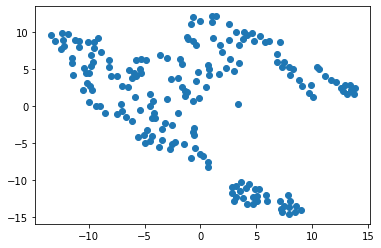

In [168]:
state = np.random.randint(100, 10000)
#state = 1156
tsne = TSNE(perplexity=24, random_state=state, metric='euclidean').fit(X)
plt.figure()
plt.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1])
plt.show()

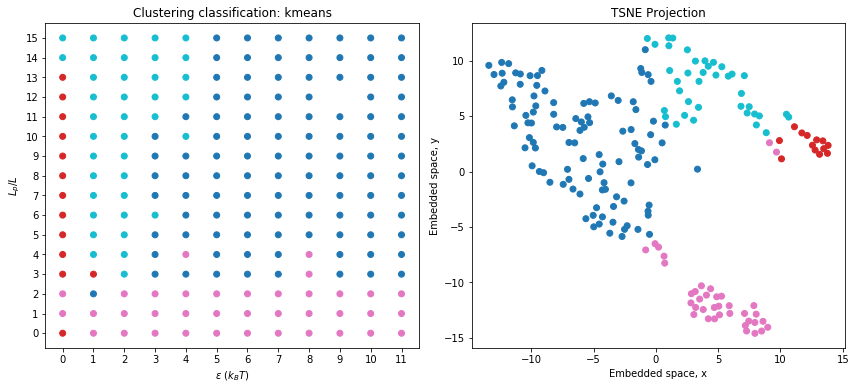

In [169]:
#state = np.random.raandint(100, 10000)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=500, random_state=state).fit(X)
plot_cluster(kmeans, tsne, X, Path(data_dir, 'plots'))

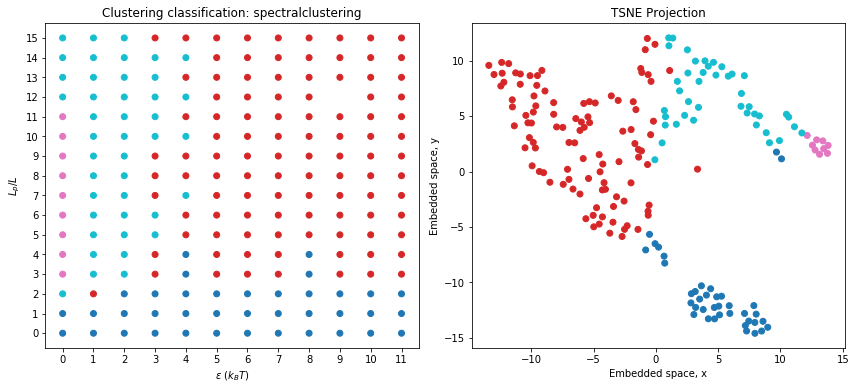

In [170]:
spectral = SpectralClustering(n_clusters=n_clusters, gamma=0.01).fit(X)
plot_cluster(spectral, tsne, X, Path(data_dir, 'plots'))

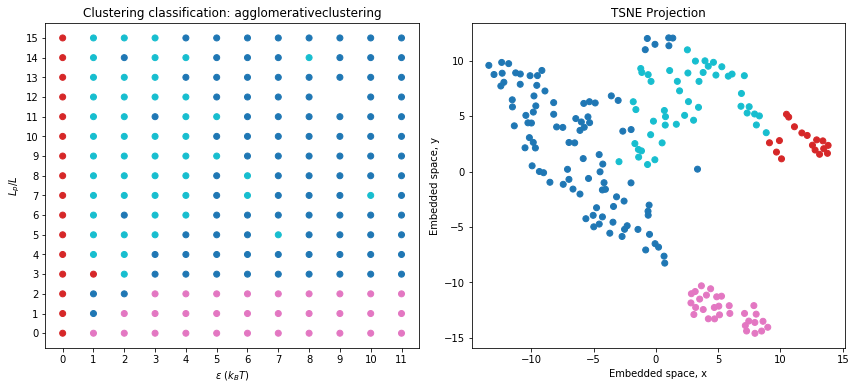

In [171]:
agglom = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
plot_cluster(agglom, tsne, X, Path(data_dir, 'plots'))

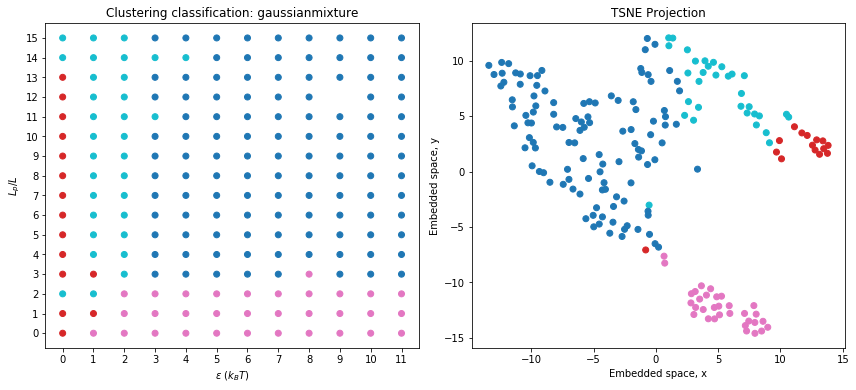

In [172]:
gmix = GaussianMixture(n_components=n_clusters, max_iter=1000, n_init=10).fit(X)
plot_cluster(gmix, tsne, X, Path(data_dir, 'plots'))